In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import sweetviz as sv

sns.set_theme(style="whitegrid")
scatterplot_marker_size = 15

Approach

We want to clean and combine all of our various datasets and export it as one CSV. This will primarily involve dropping columns that we aren't interested in and merging onto a central Pandas DataFrame. After some exploratory analysis, we will determine what rows will beed to be dropped or interpolated.

County Info

The vaccine hesitancy dataset has values for multiple segments (ethnicity, social vulnerability, vaccine hesitancy), which we will split out into separate variables and look at each. Our primary index of county codes is given by Federal Information Processing Standards (FIPS), which we extract with useful identifiers of the county (its name and state).

In [11]:
vaccine_hesitancy_data = pd.read_csv('Data/Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates.csv')

In [12]:
vaccine_hesitancy_data = pd.read_csv('Data/Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates.csv').rename(columns = {'FIPS Code':'fips'})
county = vaccine_hesitancy_data[['fips', 'County Name', 'State']].rename(columns={'County Name': 'county_name', 'State': 'state'})
county['state'] = county['state'].str.title()
county

,fips,county_name,state
0,1131,"Wilcox County, Alabama",Alabama
1,1129,"Washington County, Alabama",Alabama
2,1133,"Winston County, Alabama",Alabama
3,1127,"Walker County, Alabama",Alabama
4,2013,"Aleutians East Borough, Alaska",Alaska
...,...,...,...
3137,55079,"Milwaukee County, Wisconsin",Wisconsin
3138,55121,"Trempealeau County, Wisconsin",Wisconsin
3139,56001,"Albany County, Wyoming",Wyoming
3140,55067,"Langlade County, Wisconsin",Wisconsin


In [13]:
vaccine_hesitancy_data.head()

,fips,County Name,State,Estimated hesitant,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,State Code
0,1131,"Wilcox County, Alabama",ALABAMA,0.23,0.11,0.93,Very High Concern,0.94,Very High Concern,0.228,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684,AL
1,1129,"Washington County, Alabama",ALABAMA,0.23,0.11,0.73,High Concern,0.82,Very High Concern,0.192,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495,AL
2,1133,"Winston County, Alabama",ALABAMA,0.22,0.11,0.70,High Concern,0.80,High Concern,0.085,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370,AL
3,1127,"Walker County, Alabama",ALABAMA,0.23,0.11,0.75,High Concern,0.68,High Concern,0.158,0.0249,0.0015,0.0049,0.0617,0.0000,0.8895,AL
4,2013,"Aleutians East Borough, Alaska",ALASKA,0.26,0.12,0.58,Moderate Concern,0.87,Very High Concern,0.195,0.0901,0.4588,0.1968,0.0322,0.0100,0.1321,AK


In [14]:
regions = [(['New Jersey', 'New York', 'Pennsylvania'], 'New England', 'Northeast'), (['New Jersey', 'New York', 'Pennsylvania'], 'Midatlantic', 'Northeast'), (['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin'], 'East North Central', 'Midwest'), (['Iowa', 'Nebraska', 'Kansas', 'North Dakota', 'Minnesota', 'South Dakota', 'Missouri'], 'West North Central', 'Midwest'), (['Delaware', 'District Of Columbia', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia'], 'South Atlantic Division', 'South'), (['Alabama', 'Kentucky', 'Mississippi', 'Tennessee'], 'East South Central', 'South'), (['Arkansas', 'Louisiana', 'Oklahoma', 'Texas'], 'West South Central', 'South'), (['Arizona', 'Colorado', 'Idaho', 'New Mexico', 'Montana', 'Utah', 'Nevada', 'Wyoming'], 'Mountain', 'West'), (['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington'], 'Pacific', 'West')]

for (states, division, region) in regions:
    county.loc[county['state'].isin(states), ['division', 'region']] = [division, region]
county

,fips,county_name,state,division,region
0,1131,"Wilcox County, Alabama",Alabama,East South Central,South
1,1129,"Washington County, Alabama",Alabama,East South Central,South
2,1133,"Winston County, Alabama",Alabama,East South Central,South
3,1127,"Walker County, Alabama",Alabama,East South Central,South
4,2013,"Aleutians East Borough, Alaska",Alaska,Pacific,West
...,...,...,...,...,...
3137,55079,"Milwaukee County, Wisconsin",Wisconsin,East North Central,Midwest
3138,55121,"Trempealeau County, Wisconsin",Wisconsin,East North Central,Midwest
3139,56001,"Albany County, Wyoming",Wyoming,Mountain,West
3140,55067,"Langlade County, Wisconsin",Wisconsin,East North Central,Midwest


In [15]:
regions = [(['New Jersey', 'New York', 'Pennsylvania'], 'New England', 'Northeast'), (['New Jersey', 'New York', 'Pennsylvania'], 'Midatlantic', 'Northeast'), (['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin'], 'East North Central', 'Midwest'), (['Iowa', 'Nebraska', 'Kansas', 'North Dakota', 'Minnesota', 'South Dakota', 'Missouri'], 'West North Central', 'Midwest'), (['Delaware', 'District Of Columbia', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia'], 'South Atlantic Division', 'South'), (['Alabama', 'Kentucky', 'Mississippi', 'Tennessee'], 'East South Central', 'South'), (['Arkansas', 'Louisiana', 'Oklahoma', 'Texas'], 'West South Central', 'South'), (['Arizona', 'Colorado', 'Idaho', 'New Mexico', 'Montana', 'Utah', 'Nevada', 'Wyoming'], 'Mountain', 'West'), (['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington'], 'Pacific', 'West')]

for (states, division, region) in regions:
    county.loc[county['state'].isin(states), ['division', 'region']] = [division, region]
county

,fips,county_name,state,division,region
0,1131,"Wilcox County, Alabama",Alabama,East South Central,South
1,1129,"Washington County, Alabama",Alabama,East South Central,South
2,1133,"Winston County, Alabama",Alabama,East South Central,South
3,1127,"Walker County, Alabama",Alabama,East South Central,South
4,2013,"Aleutians East Borough, Alaska",Alaska,Pacific,West
...,...,...,...,...,...
3137,55079,"Milwaukee County, Wisconsin",Wisconsin,East North Central,Midwest
3138,55121,"Trempealeau County, Wisconsin",Wisconsin,East North Central,Midwest
3139,56001,"Albany County, Wyoming",Wyoming,Mountain,West
3140,55067,"Langlade County, Wisconsin",Wisconsin,East North Central,Midwest


Ethnicity

Percentage of ethnicity for each county are given. For readability and simplicity, we rename them with the most abundant ethnic group as primary and assume non-Hispanic for all of the non-Hispanic groups.

In [16]:
ethnicity = vaccine_hesitancy_data[['fips', 'Percent Hispanic', 'Percent non-Hispanic American Indian/Alaska Native', 'Percent non-Hispanic Asian', 'Percent non-Hispanic Black', 'Percent non-Hispanic Native Hawaiian/Pacific Islander', 'Percent non-Hispanic White']].rename(columns = {'Percent Hispanic': 'ethnicity_hispanic', 'Percent non-Hispanic American Indian/Alaska Native': 'ethnicity_native', 'Percent non-Hispanic Asian': 'ethnicity_asian', 'Percent non-Hispanic Black': 'ethnicity_black', 'Percent non-Hispanic Native Hawaiian/Pacific Islander': 'ethnicity_hawaiian', 'Percent non-Hispanic White': 'ethnicity_white'})
ethnicity

,fips,ethnicity_hispanic,ethnicity_native,ethnicity_asian,ethnicity_black,ethnicity_hawaiian,ethnicity_white
0,1131,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684
1,1129,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495
2,1133,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370
3,1127,0.0249,0.0015,0.0049,0.0617,0.0000,0.8895
4,2013,0.0901,0.4588,0.1968,0.0322,0.0100,0.1321
...,...,...,...,...,...,...,...
3137,55079,0.1500,0.0047,0.0428,0.2606,0.0002,0.5124
3138,55121,0.0840,0.0034,0.0043,0.0051,0.0000,0.8953
3139,56001,0.0953,0.0091,0.0327,0.0150,0.0003,0.8248
3140,55067,0.0197,0.0069,0.0022,0.0125,0.0002,0.9383


Social Vulnerability

In [17]:
social_vulnerability_index = vaccine_hesitancy_data[['fips', 'Social Vulnerability Index (SVI)']].rename(columns= {'Social Vulnerability Index (SVI)': 'social_vulnerability_index'})
social_vulnerability_index

,fips,social_vulnerability_index
0,1131,0.93
1,1129,0.73
2,1133,0.70
3,1127,0.75
4,2013,0.58
...,...,...
3137,55079,0.81
3138,55121,0.28
3139,56001,0.25
3140,55067,0.35


Vaccine Hesitancy

In [18]:
vaccine_hesitancy = vaccine_hesitancy_data[['fips', 'Estimated hesitant', 'Estimated strongly hesitant']].rename(columns = {'Estimated hesitant': 'vaccine_hesitant', 'Estimated strongly hesitant': 'vaccine_hesitant_strong'})
vaccine_hesitant_mean, vaccine_hesitant_std = vaccine_hesitancy['vaccine_hesitant'].mean(), vaccine_hesitancy['vaccine_hesitant'].std()
vaccine_hesitancy.loc[vaccine_hesitancy['vaccine_hesitant'] > vaccine_hesitant_mean + vaccine_hesitant_std, ['vaccine_hesitant_category']] = 'High'
vaccine_hesitancy.loc[vaccine_hesitancy['vaccine_hesitant'] < vaccine_hesitant_mean - vaccine_hesitant_std, ['vaccine_hesitant_category']] = 'Low'
vaccine_hesitancy['vaccine_hesitant_category'] = vaccine_hesitancy['vaccine_hesitant_category'].fillna('Medium')
vaccine_hesitancy

,fips,vaccine_hesitant,vaccine_hesitant_strong,vaccine_hesitant_category
0,1131,0.23,0.11,Medium
1,1129,0.23,0.11,Medium
2,1133,0.22,0.11,Medium
3,1127,0.23,0.11,Medium
4,2013,0.26,0.12,High
...,...,...,...,...
3137,55079,0.18,0.11,Medium
3138,55121,0.18,0.10,Medium
3139,56001,0.30,0.16,High
3140,55067,0.17,0.10,Medium


Education

In [19]:
education = pd.read_csv('Data/Education.csv')
education = education[['FIPS Code', 'Percent of adults with less than a high school diploma, 2015-19', 'Percent of adults with a high school diploma only, 2015-19', "Percent of adults completing some college or associate's degree, 2015-19", "Percent of adults with a bachelor's degree or higher, 2015-19"]]
education = education.rename(columns = {'FIPS Code': 'fips', 'Percent of adults with less than a high school diploma, 2015-19': 'education_high_school_less', 'Percent of adults with a high school diploma only, 2015-19': 'education_high_school_only', "Percent of adults completing some college or associate's degree, 2015-19": 'education_degree_some', "Percent of adults with a bachelor's degree or higher, 2015-19": 'education_bachelors_degree'})
education_cols = ['education_high_school_less', 'education_high_school_only', 'education_degree_some', 'education_bachelors_degree']
education[education_cols] = education[education_cols].div(100)
education

,fips,education_high_school_less,education_high_school_only,education_degree_some,education_bachelors_degree
0,0,0.120,0.270,0.289,0.321
1,1000,0.138,0.308,0.299,0.255
2,1001,0.115,0.336,0.284,0.266
3,1003,0.092,0.277,0.313,0.319
4,1005,0.268,0.356,0.260,0.116
...,...,...,...,...,...
3278,72145,0.284,0.262,0.241,0.212
3279,72147,0.288,0.392,0.140,0.180
3280,72149,0.220,0.384,0.197,0.199
3281,72151,0.290,0.257,0.272,0.180


Finding missing data

In [20]:
# Show missing county rows in education dataset
county[~county['fips'].isin(education['fips'])]

,fips,county_name,state,division,region


Poverty

In [21]:
poverty = pd.read_csv('Data/PovertyEstimates.csv')
poverty = poverty[['FIPStxt', 'Attribute', 'Value']].pivot(index='FIPStxt', columns='Attribute', values='Value').reset_index()
poverty = poverty[['FIPStxt', 'PCTPOVALL_2019']].rename(columns = {'FIPStxt':'fips', 'PCTPOVALL_2019': 'poverty'})
poverty['poverty'] = poverty['poverty'].div(100)
poverty

Attribute,fips,poverty
0,0,0.123
1,1000,0.156
2,1001,0.121
3,1003,0.101
4,1005,0.271
...,...,...
3188,56037,0.083
3189,56039,0.060
3190,56041,0.085
3191,56043,0.111


In [22]:
# Show missing county rows in poverty dataset
county[~county['fips'].isin(poverty['fips'])]

,fips,county_name,state,division,region
48,15005,"Kalawao County, Hawaii",Hawaii,Pacific,West


Natality

In [23]:
natality = pd.read_csv('Data/PopulationEstimates.csv')
natality = natality[['FIPStxt', 'POP_ESTIMATE_2019', 'R_birth_2019']].rename(columns = {'FIPStxt': 'fips', 'POP_ESTIMATE_2019': 'population', 'R_birth_2019': 'birth_rate'})
natality['birth_rate'] = natality['birth_rate'].div(100)
natality

,fips,population,birth_rate
0,0,"328,239,523",NaN
1,1000,"4,903,185",0.117
2,1001,"55,869",0.112
3,1003,"223,234",0.104
4,1005,"24,686",0.103
...,...,...,...
3268,72145,"50,023",NaN
3269,72147,"8,386",NaN
3270,72149,"21,372",NaN
3271,72151,"32,282",NaN


In [24]:
# Show missing county rows in natality dataset
county[~county['fips'].isin(natality['fips'])]

,fips,county_name,state,division,region


Elections

In [25]:
election_years = [2008, 2012, 2016, 2020]
def election_winner(row, year):
    if row['dem_' + str(year)] > row['gop_' + str(year)]:
        return 'Democrat'
    else:
        return 'Republican'
elections_data = pd.read_csv('Data/US_County_Level_Presidential_Results_08-16.csv').rename(columns={'fips_code': 'fips'})
elections_data_2020 = pd.read_csv('Data/2020_US_County_Level_Presidential_Results.csv').rename(columns={'votes_gop': 'gop_2020', 'votes_dem': 'dem_2020', 'county_fips': 'fips'})
elections_data = elections_data.merge(elections_data_2020[['fips', 'gop_2020', 'dem_2020']], left_on='fips', right_on='fips')
elections = pd.DataFrame()
elections['fips'] = elections_data['fips']
for year in election_years:
    elections['election_' + str(year)] = elections_data.apply(lambda row: election_winner(row, year), axis=1)
elections

,fips,election_2008,election_2012,election_2016,election_2020
0,26041,Democrat,Republican,Republican,Republican
1,48295,Republican,Republican,Republican,Republican
2,1127,Republican,Republican,Republican,Republican
3,48389,Democrat,Democrat,Democrat,Republican
4,56017,Republican,Republican,Republican,Republican
...,...,...,...,...,...
3106,17115,Democrat,Republican,Republican,Republican
3107,29215,Republican,Republican,Republican,Republican
3108,46051,Republican,Republican,Republican,Republican
3109,17103,Republican,Republican,Republican,Republican


In [26]:
elections['election_democrat_wins'] = sum([elections['election_' + str(year)].str.count('Democrat') for year in election_years])
elections['election_republican_wins'] = sum([elections['election_' + str(year)].str.count('Republican') for year in election_years])
elections = elections[['fips', 'election_democrat_wins', 'election_republican_wins']]
elections

,fips,election_democrat_wins,election_republican_wins
0,26041,1,3
1,48295,0,4
2,1127,0,4
3,48389,3,1
4,56017,0,4
...,...,...,...
3106,17115,1,3
3107,29215,0,4
3108,46051,0,4
3109,17103,0,4


In [27]:
# Show missing county rows in elections dataset
county[~county['fips'].isin(elections['fips'])]

,fips,county_name,state,division,region
4,2013,"Aleutians East Borough, Alaska",Alaska,Pacific,West
5,2016,"Aleutians West Census Area, Alaska",Alaska,Pacific,West
24,2050,"Bethel Census Area, Alaska",Alaska,Pacific,West
48,15005,"Kalawao County, Hawaii",Hawaii,Pacific,West
371,2020,"Anchorage Municipality, Alaska",Alaska,Pacific,West
375,2198,"Prince of Wales-Hyder Census Area, Alaska",Alaska,Pacific,West
392,2275,"Wrangell City and Borough, Alaska",Alaska,Pacific,West
394,2122,"Kenai Peninsula Borough, Alaska",Alaska,Pacific,West
398,2180,"Nome Census Area, Alaska",Alaska,Pacific,West
402,2261,"Valdez-Cordova Census Area, Alaska",Alaska,Pacific,West


Unemployment

From the Unemployment dataset, we have several useful data points involving geography (rural vs urban continuum code, urban influence code), income (median household, and represented as a percent of median state total) and unemployment rate.

In [28]:
unemployment = pd.read_csv('Data/Unemployment.csv').pivot(index='fips_txt', columns='Attribute', values='Value').reset_index().rename(columns = {'fips_txt':'fips'})
geography = unemployment[['fips', 'Rural_urban_continuum_code_2013', 'Urban_influence_code_2013']].rename(columns={'Rural_urban_continuum_code_2013': 'rural_urban_code', 'Urban_influence_code_2013': 'urban_influence_code'})
# TODO: convert urban/rural codes into z-scores
geography

Attribute,fips,rural_urban_code,urban_influence_code
0,0,NaN,NaN
1,1000,NaN,NaN
2,1001,2.0,2.0
3,1003,3.0,2.0
4,1005,6.0,6.0
...,...,...,...
3270,72145,1.0,1.0
3271,72147,7.0,12.0
3272,72149,2.0,2.0
3273,72151,1.0,1.0


In [29]:
# Show missing county rows in geography dataset
county[~county['fips'].isin(geography['fips'])]

,fips,county_name,state,division,region
48,15005,"Kalawao County, Hawaii",Hawaii,Pacific,West


Income

To look at the county's economic factors, we keep two columns representing the estimated median household income in 2019 and the county household median income as a percent of the state total median household income. We represent this percent as a decimal.

In [30]:
income = unemployment[['fips', 'Med_HH_Income_Percent_of_State_Total_2019', 'Median_Household_Income_2019']].rename(columns={'Med_HH_Income_Percent_of_State_Total_2019': 'median_income_percent_state', 'Median_Household_Income_2019': 'median_income'})
income['median_income_percent_state'] = income['median_income_percent_state'].div(100)
income

Attribute,fips,median_income_percent_state,median_income
0,0,NaN,65712.0
1,1000,1.000000,51771.0
2,1001,1.124819,58233.0
3,1003,1.156458,59871.0
4,1005,0.694829,35972.0
...,...,...,...
3270,72145,NaN,NaN
3271,72147,NaN,NaN
3272,72149,NaN,NaN
3273,72151,NaN,NaN


In [31]:
# Show missing county rows in income dataset
county[~county['fips'].isin(income['fips'])]

,fips,county_name,state,division,region
48,15005,"Kalawao County, Hawaii",Hawaii,Pacific,West


Unemployment

In [32]:
unemployment = unemployment[['fips', 'Unemployment_rate_2019']].rename(columns={'Unemployment_rate_2019': 'unemployment'})
unemployment['unemployment'] = unemployment['unemployment'].div(100)
unemployment

Attribute,fips,unemployment
0,0,0.036694
1,1000,0.030000
2,1001,0.027000
3,1003,0.027000
4,1005,0.038000
...,...,...
3270,72145,0.096000
3271,72147,0.069000
3272,72149,0.159000
3273,72151,0.131000


In [33]:
# Show missing county rows in unemployment dataset
county[~county['fips'].isin(unemployment['fips'])]

,fips,county_name,state,division,region
48,15005,"Kalawao County, Hawaii",Hawaii,Pacific,West


Religion

In [34]:
religion = pd.read_csv('Data/U.S. Religion Census Religious Congregations and Membership Study, 2010 (County File).csv')
religion = religion[['FIPS', 'TOTRATE', 'EVANRATE', 'MPRTRATE']].rename(columns = {'FIPS': 'fips', 'TOTRATE': 'religion_total', 'EVANRATE': 'religion_evangelical', 'MPRTRATE': 'religion_mainline_protestant'})
religion
# TODO: decide to drop black_protestant and/or orthodox columns

,fips,religion_total,religion_evangelical,religion_mainline_protestant
0,1001,676.878889,503.990000,82.858889
1,1003,531.740000,318.138889,110.140000
2,1005,549.990000,320.250000,77.938889
3,1007,498.800000,443.328889,13.178889
4,1009,651.620000,509.800000,52.950000
...,...,...,...,...
3144,56037,477.220000,99.120000,31.230000
3145,56039,260.360000,42.030000,85.468889
3146,56041,606.830000,68.658889,23.488889
3147,56043,471.818889,155.870000,88.708889


In [35]:
# Show missing county rows in religion dataset
county[~county['fips'].isin(religion['fips'])]

,fips,county_name,state,division,region
456,2158,"Kusilvak Census Area, Alaska",Alaska,Pacific,West
2724,46102,"Oglala Lakota County, South Dakota",South Dakota,West North Central,Midwest


In [36]:
# Show missing value county rows in religion_total column
county[county['fips'].isin(religion[religion['religion_total'].isnull()]['fips'])]

,fips,county_name,state,division,region


In [37]:
# Show missing value county rows in religion_evangelical column
county[county['fips'].isin(religion[religion['religion_evangelical'].isnull()]['fips'])]

,fips,county_name,state,division,region
48,15005,"Kalawao County, Hawaii",Hawaii,Pacific,West
492,2164,"Lake and Peninsula Borough, Alaska",Alaska,Pacific,West
635,8047,"Gilpin County, Colorado",Colorado,Mountain,West
643,8023,"Costilla County, Colorado",Colorado,Mountain,West
889,16033,"Clark County, Idaho",Idaho,Mountain,West
1883,30069,"Petroleum County, Montana",Montana,Mountain,West
1976,31113,"Logan County, Nebraska",Nebraska,West North Central,Midwest
2043,31005,"Arthur County, Nebraska",Nebraska,West North Central,Midwest
2231,38087,"Slope County, North Dakota",North Dakota,West North Central,Midwest
2282,38065,"Oliver County, North Dakota",North Dakota,West North Central,Midwest


In [38]:
# Show missing value county rows in religion_evangelical column
county[county['fips'].isin(religion[religion['religion_mainline_protestant'].isnull()]['fips'])]

,fips,county_name,state,division,region
4,2013,"Aleutians East Borough, Alaska",Alaska,Pacific,West
25,55078,"Menominee County, Wisconsin",Wisconsin,East North Central,Midwest
208,48301,"Loving County, Texas",Texas,West South Central,South
221,48311,"McMullen County, Texas",Texas,West South Central,South
290,51685,"Manassas Park city, Virginia",Virginia,South Atlantic Division,South
449,2060,"Bristol Bay Borough, Alaska",Alaska,Pacific,West
476,2068,"Denali Borough, Alaska",Alaska,Pacific,West
492,2164,"Lake and Peninsula Borough, Alaska",Alaska,Pacific,West
503,2282,"Yakutat City and Borough, Alaska",Alaska,Pacific,West
553,6003,"Alpine County, California",California,Pacific,West


Data Completeness

As noted above we are missing a few recurring pattern of certain counties being missing in most of our datasets.

Oglala Lakota County, South Dakota (FIPS 46102)
Kalawao County, Hawaii (FIPS 15005)
Various parts of Alaska, especially in the election dataset
Upon further investigation into those areas, we learned that Oglala Lakota County does not have a functioning county seat and remains unorganized, which explains the difficulty government surveyers would have with gathering data there. However, this county is entirely on an Indian reservation, which would give us valuable insight on Native American vaccine hesitancy.

Kalawao County because of its small population does not have many of the functions that a normal county would have.

While Alaska does administer using county divisions, for elections they use a different geographic boundary of boroughs, which do not conveniently align with counties. This makes a county level political correlation with vaccine hesitancy impossible for us. Similar to the note above, Alaska is home to a lot of Native Americans, 15% of the population, which means our analysis will lose insight into Native American vaccine hesitancy.

Because of the issues surrounding population size, county organization and governmental issues, we decide to drop those two data points and focus our analysis on the central parts of USA, ignoring Alaska.

In [39]:
county = county.drop(county[county['fips'] == 46102].index)
county = county.drop(county[county['fips'] == 15005].index)
county = county.drop(county[county['state'] == 'Alaska'].index)
county

,fips,county_name,state,division,region
0,1131,"Wilcox County, Alabama",Alabama,East South Central,South
1,1129,"Washington County, Alabama",Alabama,East South Central,South
2,1133,"Winston County, Alabama",Alabama,East South Central,South
3,1127,"Walker County, Alabama",Alabama,East South Central,South
6,1125,"Tuscaloosa County, Alabama",Alabama,East South Central,South
...,...,...,...,...,...
3137,55079,"Milwaukee County, Wisconsin",Wisconsin,East North Central,Midwest
3138,55121,"Trempealeau County, Wisconsin",Wisconsin,East North Central,Midwest
3139,56001,"Albany County, Wyoming",Wyoming,Mountain,West
3140,55067,"Langlade County, Wisconsin",Wisconsin,East North Central,Midwest


Aggregation

We set the fips as index for all of our dataframes and then concatenate them along it with an inner join. We note that there's only one row that was lost.

In [40]:
dfs = [df.set_index('fips') for df in [county, vaccine_hesitancy, social_vulnerability_index, ethnicity, natality, unemployment, geography, income, poverty, education, religion, elections]]
df = pd.concat(dfs, axis=1, join='inner').reset_index()
df

,fips,county_name,state,division,region,vaccine_hesitant,vaccine_hesitant_strong,vaccine_hesitant_category,social_vulnerability_index,ethnicity_hispanic,...,poverty,education_high_school_less,education_high_school_only,education_degree_some,education_bachelors_degree,religion_total,religion_evangelical,religion_mainline_protestant,election_democrat_wins,election_republican_wins
0,1131,"Wilcox County, Alabama",Alabama,East South Central,South,0.23,0.11,Medium,0.93,0.0053,...,0.325,0.235,0.395,0.245,0.125,610.450000,294.938889,48.670000,4,0
1,1129,"Washington County, Alabama",Alabama,East South Central,South,0.23,0.11,Medium,0.73,0.0146,...,0.186,0.174,0.431,0.269,0.127,584.950000,420.398889,70.640000,0,4
2,1133,"Winston County, Alabama",Alabama,East South Central,South,0.22,0.11,Medium,0.70,0.0315,...,0.167,0.212,0.382,0.278,0.128,611.580000,551.340000,45.618889,0,4
3,1127,"Walker County, Alabama",Alabama,East South Central,South,0.23,0.11,Medium,0.75,0.0249,...,0.173,0.182,0.375,0.330,0.113,653.508889,583.648889,38.078889,0,4
4,1125,"Tuscaloosa County, Alabama",Alabama,East South Central,South,0.22,0.10,Medium,0.63,0.0372,...,0.162,0.117,0.299,0.277,0.307,535.888889,368.870000,63.780000,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,55079,"Milwaukee County, Wisconsin",Wisconsin,East North Central,Midwest,0.18,0.11,Medium,0.81,0.1500,...,0.169,0.117,0.284,0.290,0.310,463.758889,122.708889,54.500000,4,0
3107,55121,"Trempealeau County, Wisconsin",Wisconsin,East North Central,Midwest,0.18,0.10,Medium,0.28,0.0840,...,0.089,0.093,0.390,0.324,0.193,736.360000,58.578889,410.220000,2,2
3108,56001,"Albany County, Wyoming",Wyoming,Mountain,West,0.30,0.16,High,0.25,0.0953,...,0.160,0.041,0.147,0.295,0.518,360.120000,67.250000,67.048889,2,2
3109,55067,"Langlade County, Wisconsin",Wisconsin,East North Central,Midwest,0.17,0.10,Medium,0.35,0.0197,...,0.130,0.097,0.423,0.313,0.167,654.350000,199.030000,85.048889,1,3


EXPLORATORY DATA ANALYSIS

In [44]:
df.to_csv('Cleaned Data/interim_clean_dataset_2021-06-06.csv', index=False)
df.head()

,fips,county_name,state,division,region,vaccine_hesitant,vaccine_hesitant_strong,vaccine_hesitant_category,social_vulnerability_index,ethnicity_hispanic,...,poverty,education_high_school_less,education_high_school_only,education_degree_some,education_bachelors_degree,religion_total,religion_evangelical,religion_mainline_protestant,election_democrat_wins,election_republican_wins
0,1131,"Wilcox County, Alabama",Alabama,East South Central,South,0.23,0.11,Medium,0.93,0.0053,...,0.325,0.235,0.395,0.245,0.125,610.450000,294.938889,48.670000,4,0
1,1129,"Washington County, Alabama",Alabama,East South Central,South,0.23,0.11,Medium,0.73,0.0146,...,0.186,0.174,0.431,0.269,0.127,584.950000,420.398889,70.640000,0,4
2,1133,"Winston County, Alabama",Alabama,East South Central,South,0.22,0.11,Medium,0.70,0.0315,...,0.167,0.212,0.382,0.278,0.128,611.580000,551.340000,45.618889,0,4
3,1127,"Walker County, Alabama",Alabama,East South Central,South,0.23,0.11,Medium,0.75,0.0249,...,0.173,0.182,0.375,0.330,0.113,653.508889,583.648889,38.078889,0,4
4,1125,"Tuscaloosa County, Alabama",Alabama,East South Central,South,0.22,0.10,Medium,0.63,0.0372,...,0.162,0.117,0.299,0.277,0.307,535.888889,368.870000,63.780000,0,4


In [45]:
# TODO: Bar charts (univariate) to explore vaccine hesitancy cluster groups along demographic data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3111 entries, 0 to 3110
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   fips                          3111 non-null   int64  
 1   county_name                   3111 non-null   object 
 2   state                         3111 non-null   object 
 3   division                      3044 non-null   object 
 4   region                        3044 non-null   object 
 5   vaccine_hesitant              3111 non-null   float64
 6   vaccine_hesitant_strong       3111 non-null   float64
 7   vaccine_hesitant_category     3111 non-null   object 
 8   social_vulnerability_index    3110 non-null   float64
 9   ethnicity_hispanic            3111 non-null   float64
 10  ethnicity_native              3111 non-null   float64
 11  ethnicity_asian               3111 non-null   float64
 12  ethnicity_black               3111 non-null   float64
 13  eth

Vaccine Hesitancy


Vaccine Hesitant

In [46]:
df['vaccine_hesitant'].describe()


count    3111.000000
mean        0.194744
std         0.046197
min         0.060000
25%         0.170000
50%         0.190000
75%         0.220000
max         0.320000
Name: vaccine_hesitant, dtype: float64

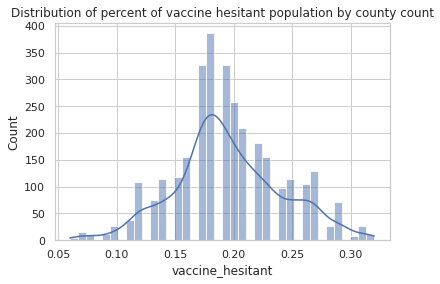

In [47]:
vaccine_hesitant_histogram = sns.histplot(data=df, x='vaccine_hesitant', kde=True).set_title('Distribution of percent of vaccine hesitant population by county count')

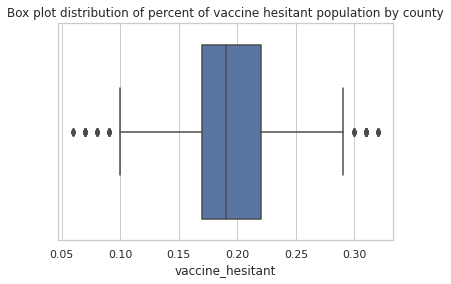

In [48]:
vaccine_hesitant_boxplot = sns.boxplot(data=df, x='vaccine_hesitant').set_title('Box plot distribution of percent of vaccine hesitant population by county')


The vaccine hesitant population is distributed normally more or less with a very slight right skew, however that isn't too significant. There are slightly more outliers on the less hesitant side than the very hesitant side.

In [49]:
df['vaccine_hesitant_strong'].describe()

count    3111.000000
mean        0.092086
std         0.029398
min         0.020000
25%         0.070000
50%         0.090000
75%         0.110000
max         0.200000
Name: vaccine_hesitant_strong, dtype: float64

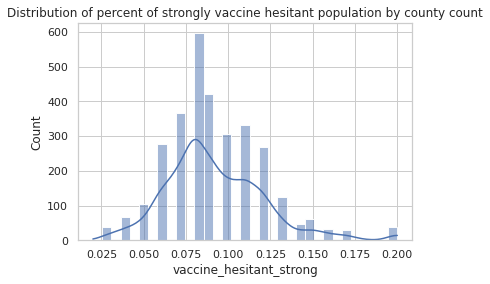

In [50]:
vaccine_hesitant_strong_histogram = sns.histplot(data=df, x='vaccine_hesitant_strong', kde=True).set_title('Distribution of percent of strongly vaccine hesitant population by county count')


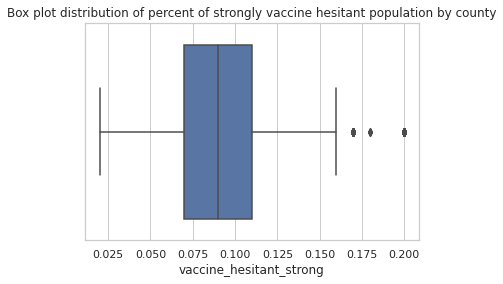

In [51]:
vaccine_hesitant_strong_boxplot = sns.boxplot(data=df, x='vaccine_hesitant_strong').set_title('Box plot distribution of percent of strongly vaccine hesitant population by county')


The strongly vaccine hesitant distribution is also normally distributed, but seemingly less so this time. The distribution has a slight right skew. There are much more outliers on the hesitant side than there are on the less hesitant (the opposite of the last vaccine_hesitant distribution).

TODO: is this a fat tailed distribution?

Ethnicity

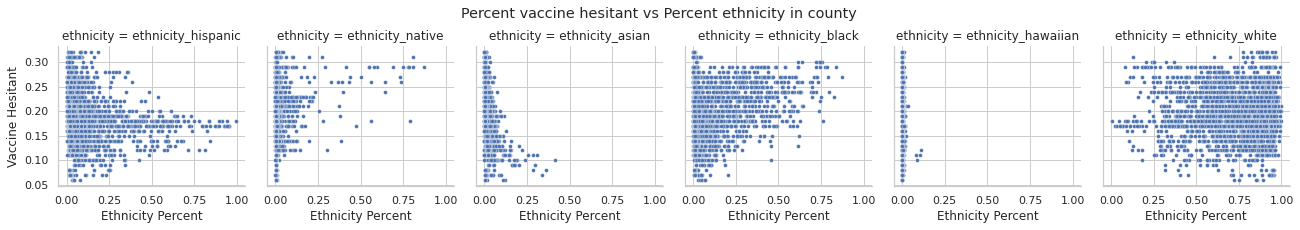

In [52]:
df_narrow_ethnicity = df.melt(id_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_vars=['ethnicity_hispanic', 'ethnicity_native', 'ethnicity_asian', 'ethnicity_black', 'ethnicity_hawaiian', 'ethnicity_white'], var_name='ethnicity')
graph = sns.FacetGrid(df_narrow_ethnicity, col='ethnicity')
graph.map_dataframe(sns.scatterplot, x='value', y='vaccine_hesitant', s=scatterplot_marker_size)
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle('Percent vaccine hesitant vs Percent ethnicity in county')
_ = graph.set_axis_labels("Ethnicity Percent", "Vaccine Hesitant")
# TODO: Figure out better way to visualize. Group dots into larger points?

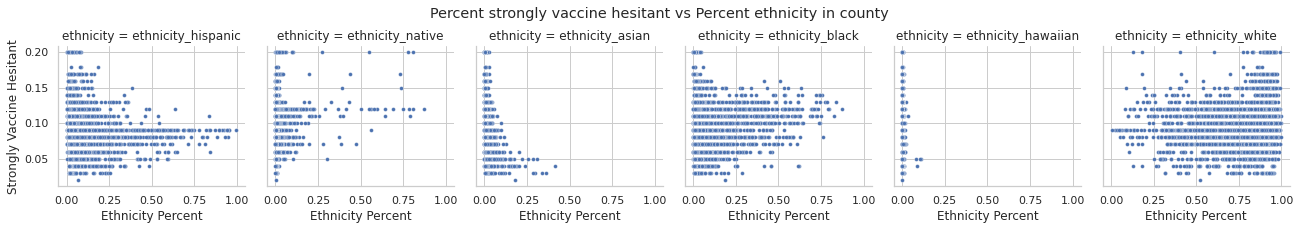

In [53]:
graph = sns.FacetGrid(df_narrow_ethnicity, col='ethnicity')
graph.map_dataframe(sns.scatterplot, x='value', y='vaccine_hesitant_strong', s=scatterplot_marker_size)
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle('Percent strongly vaccine hesitant vs Percent ethnicity in county')
_ = graph.set_axis_labels("Ethnicity Percent", "Strongly Vaccine Hesitant")

Our ethnicity plots don't show a strong relationship between vaccine hesitancy and county ethnic composition. It's difficult to tell in some cases because of the low minority population in many counties, which tend to show a plot clustered around the y-axis.

The Hispanic plots show an almost 2D bell curve distribution with a normal at 18% vaccine hesitant and 9% strongly vaccine hesitant. Both of these figures are similar to the overall total vaccine hesitant distributions above.

Counties with higher Native populations seem to be more highly vaccine hesitant. However the vast majority of counties have a very small Native population, which is somewhat normally distributed along vaccine hesitancy.

Counties with higher Asian populations tend to be less vaccine hesitant and strongly vaccine hesitant.

Counties with higher Black populations seem to have a higher percent of vaccine hesitant, but not strongly vaccine hesitant populations.

Counties with a larger Hawaiian composition tend to be evenly distributed along vaccine hesitancy except for a small modal bump at a very low vaccine hesitancy of 10% and strongly vaccine hesitant 5%.

The strongly vaccine hesitant white show an almost 2D bell curve distribution with a normal at 10%. The vaccine hesitant graph doesn't show a clear relationship

Geography

Region

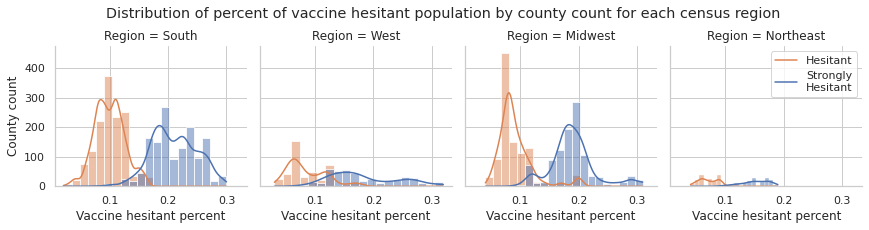

In [54]:
df_narrow_region = df.melt(id_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_vars=['region'], value_name='Region')
graph = sns.FacetGrid(df_narrow_region, col='Region')
graph.map_dataframe(sns.histplot, bins=20, kde=True)
graph.fig.subplots_adjust(top=0.8)
plt.legend(labels=["Hesitant","Strongly\nHesitant"])
graph.fig.suptitle('Distribution of percent of vaccine hesitant population by county count for each census region')
_ = graph.set_axis_labels("Vaccine hesitant percent", "County count")

We look at the vaccine hesitant and strongly vaccine hesitant populations by census region. The south and midwest have a very differentiated distribution of the two variables with little overlap. The west and northeast have much more of an overlap. This suggest that opinion on vaccine hesitancy may be more poplarized in the south and midwest.

Division

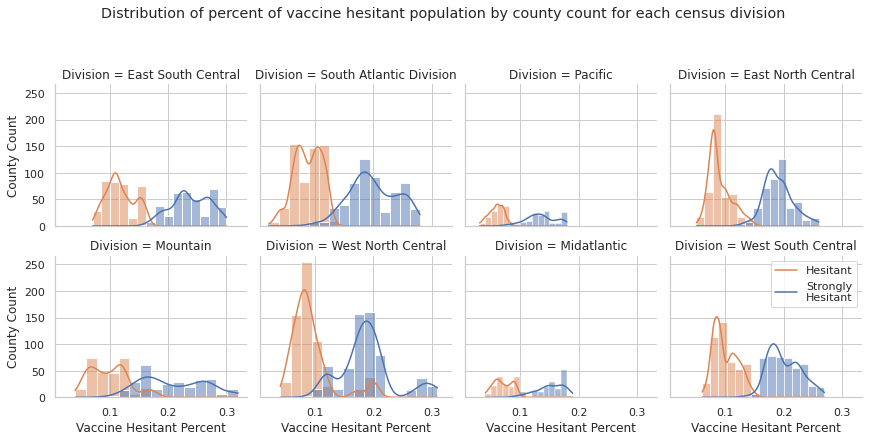

In [56]:
df_narrow_division = df.melt(id_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_vars=['division'], value_name='Division')
graph = sns.FacetGrid(df_narrow_division, col='Division', col_wrap=4)
graph.map_dataframe(sns.histplot, bins=15, kde=True)
graph.fig.subplots_adjust(top=0.8)
plt.legend(labels=["Hesitant","Strongly\nHesitant"])
graph.fig.suptitle('Distribution of percent of vaccine hesitant population by county count for each census division')
_ = graph.set_axis_labels("Vaccine Hesitant Percent", "County Count")

State

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


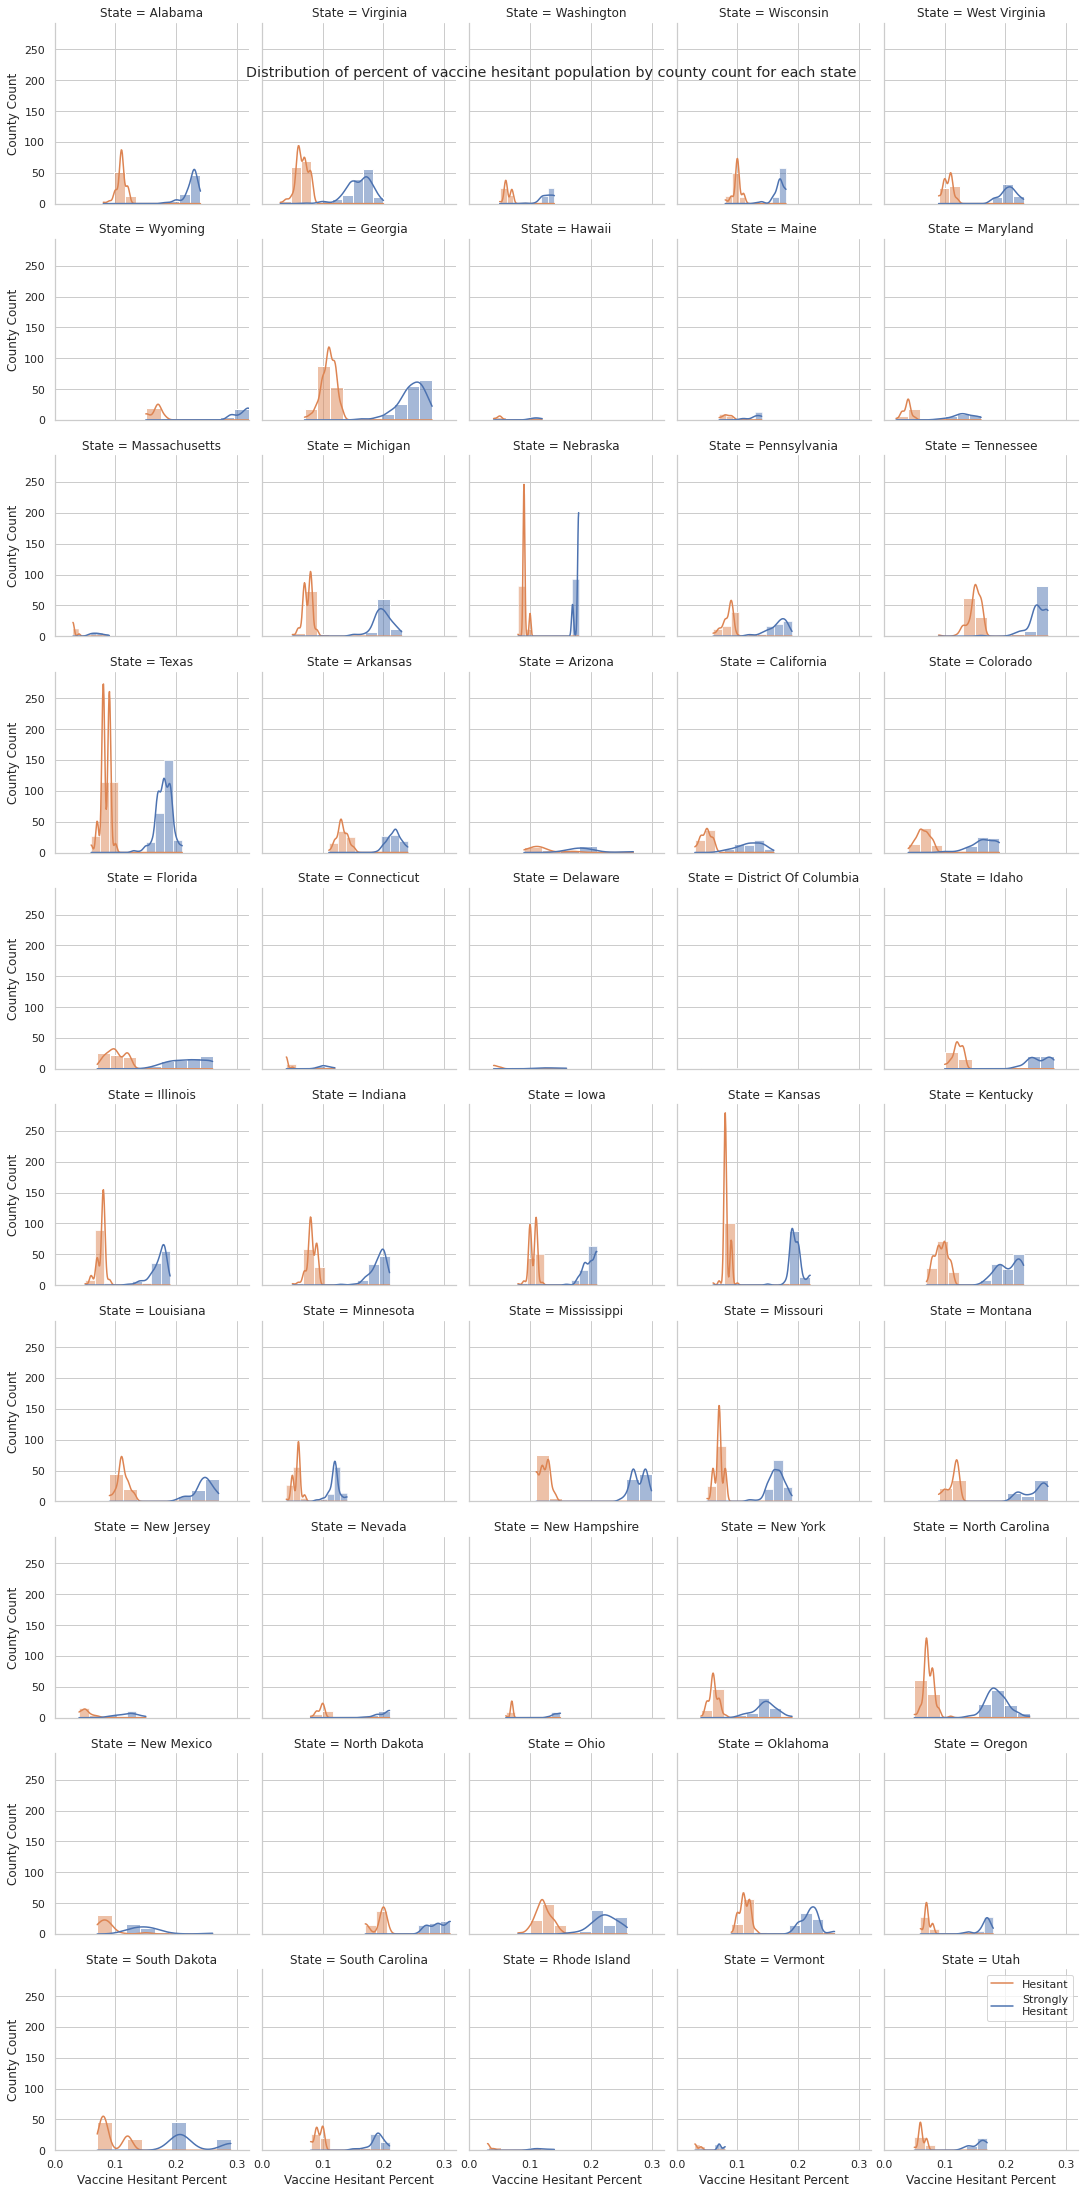

In [57]:
df_narrow_state = df.melt(id_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_vars=['state'], value_name='State')
graph = sns.FacetGrid(df_narrow_state, col='State', col_wrap=5)
graph.map_dataframe(sns.histplot, kde=True)
graph.set_axis_labels("Vaccine Hesitant Percent", "County Count")
plt.legend(labels=["Hesitant","Strongly\nHesitant"])
graph.fig.subplots_adjust(top=1)
graph.fig.suptitle('Distribution of percent of vaccine hesitant population by county count for each state')
_ = plt.xlim(0, 0.32)

# TODO: check variances of all states, fix title

Rural Urban Code

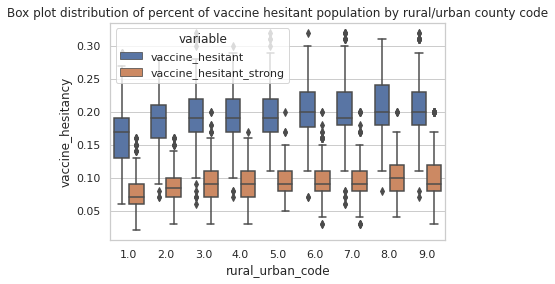

In [58]:
df_narrow_rural_urban = df.melt(id_vars=['rural_urban_code'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
rural_urban_code_boxplot = sns.boxplot(data=df_narrow_rural_urban, x='rural_urban_code', y='vaccine_hesitancy', hue='variable').set_title('Box plot distribution of percent of vaccine hesitant population by rural/urban county code')

We see a slight increase in vaccine hesitant and strongly vaccine hesitant populations with an increase in the rural urban code. This suggests that more rural counties may have higher vaccine hesitant populations.

Urban Influence Code

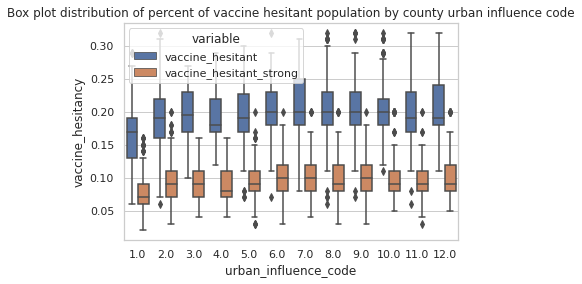

In [61]:
df_narrow_urban_influence = df.melt(id_vars=['urban_influence_code'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
urban_influence_code_boxplot = sns.boxplot(data=df_narrow_urban_influence, x='urban_influence_code', y='vaccine_hesitancy', hue='variable').set_title('Box plot distribution of percent of vaccine hesitant population by county urban influence code')

Population

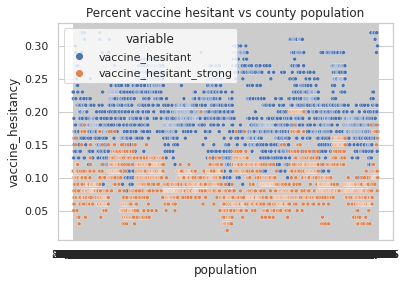

In [76]:
df_narrow_population = df.melt(id_vars=['population'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
population_scatterplot = sns.scatterplot(data=df_narrow_population, x='population', y='vaccine_hesitancy', hue='variable', s=scatterplot_marker_size).set_title('Percent vaccine hesitant vs county population')

Birth Rate

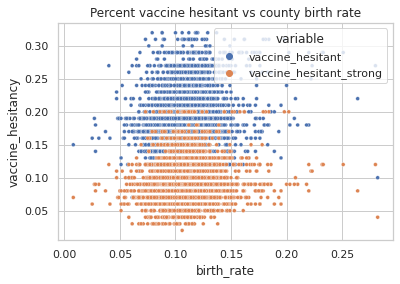

In [64]:
df_narrow_birth_rate = df.melt(id_vars=['birth_rate'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
birth_rate_scatterplot = sns.scatterplot(data=df_narrow_birth_rate, x='birth_rate', y='vaccine_hesitancy', hue='variable', s=scatterplot_marker_size).set_title('Percent vaccine hesitant vs county birth rate')
# birth_rate_scatterplot = sns.scatterplot(data=df, x='birth_rate', y='vaccine_hesitant', s=scatterplot_marker_size).set_title('Percent vaccine hesitant vs county birth rate')

Economic

In [66]:
# median_income_scatterplot = sns.scatterplot(data=df, x='median_income', y='vaccine_hesitant', s=scatterplot_marker_size).set_title('Percent vaccine hesitant vs county median household income')

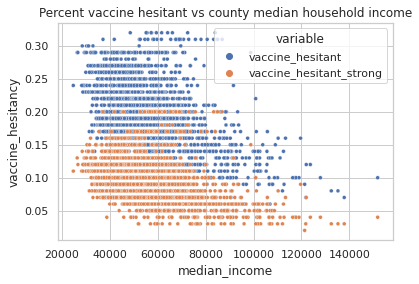

In [67]:
df_narrow_median_income = df.melt(id_vars=['median_income'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
median_income_scatterplot = sns.scatterplot(data=df_narrow_median_income, x='median_income', y='vaccine_hesitancy', hue='variable', s=scatterplot_marker_size).set_title('Percent vaccine hesitant vs county median household income')

We see an inverse relationship between both vaccine hesitant and strongly vaccine hesitant populations and median household income. The relationship seems to be stronger with the strongly vaccine hesitant population.

In [68]:
# median_income_percent_state_scatterplot = sns.scatterplot(data=df, x='median_income_percent_state', y='vaccine_hesitant', s=scatterplot_marker_size)
# TODO: drop column. superfluous with median_income?

This scatterplot of median household income as a percent of the state income shows more or less the same thing as the median household income. We will drop this from our dataset.

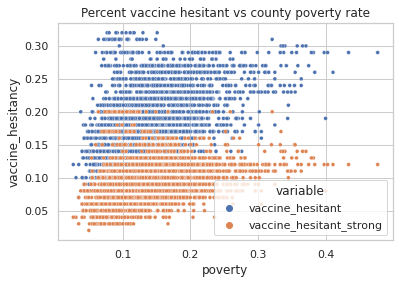

In [69]:
df_narrow_poverty = df.melt(id_vars=['poverty'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
poverty_scatterplot = sns.scatterplot(data=df_narrow_poverty, x='poverty', y='vaccine_hesitancy', hue='variable', s=scatterplot_marker_size).set_title('Percent vaccine hesitant vs county poverty rate')
# poverty_scatterplot = sns.scatterplot(data=df, x='poverty', y='vaccine_hesitant', s=scatterplot_marker_size).set_title('Percent vaccine hesitant vs county poverty rate')

Education

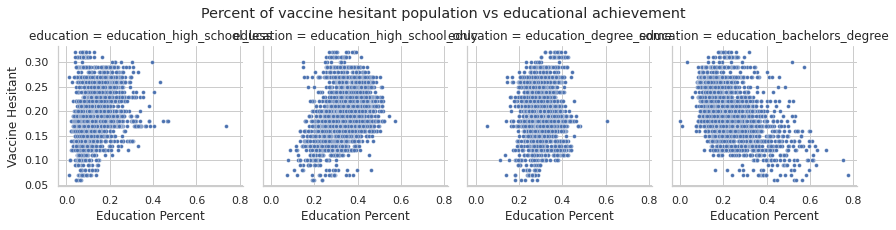

In [70]:
df_narrow_education = pd.melt(df, id_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_vars=['education_high_school_less', 'education_high_school_only', 'education_degree_some', 'education_bachelors_degree'], var_name='education')
# df_narrow_education = df.melt(id_vars=['poverty'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
graph = sns.FacetGrid(df_narrow_education, col='education')
graph.map_dataframe(sns.scatterplot, x='value', y='vaccine_hesitant', s=scatterplot_marker_size)
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle('Percent of vaccine hesitant population vs educational achievement')
_ = graph.set_axis_labels("Education Percent", "Vaccine Hesitant")

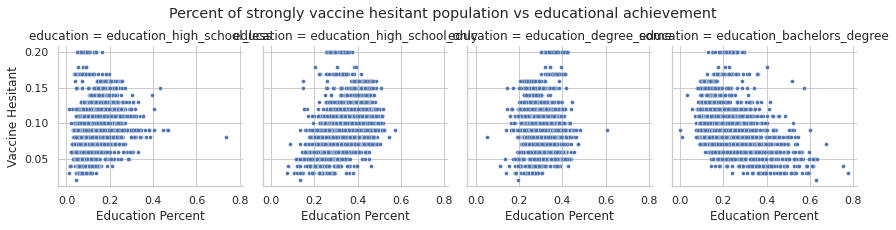

In [71]:
graph = sns.FacetGrid(df_narrow_education, col='education')
graph.map_dataframe(sns.scatterplot, x='value', y='vaccine_hesitant_strong', s=scatterplot_marker_size)
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle('Percent of strongly vaccine hesitant population vs educational achievement')
_ = graph.set_axis_labels("Education Percent", "Vaccine Hesitant")

For the two plots for less than high school education, we see a slight linear relationship between vaccine hesitancy and increase of percent of less than high school education population.

This relationship weakens with the more educated high school graduate only plots.

The some post-secondary degree group does not have a significant relationship.

The bachelors degree and higher graphs show an inverse relationship between the amount of population with a bachelors degree and vaccine hesitancy.

Religion

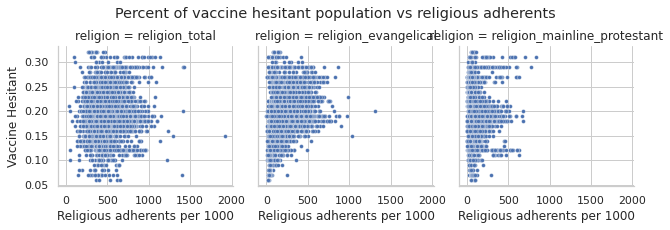

In [72]:
# df_narrow_religion = df.melt(id_vars=['religion_total', 'religion_evangelical', 'religion_mainline_protestant'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='Religion')
df_narrow_religion = pd.melt(df, id_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_vars=['religion_total', 'religion_evangelical', 'religion_mainline_protestant'], var_name='religion')
graph = sns.FacetGrid(df_narrow_religion, col='religion')
graph.map_dataframe(sns.scatterplot, x='value', y='vaccine_hesitant', s=scatterplot_marker_size)
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle('Percent of vaccine hesitant population vs religious adherents')
_ = graph.set_axis_labels("Religious adherents per 1000", "Vaccine Hesitant")

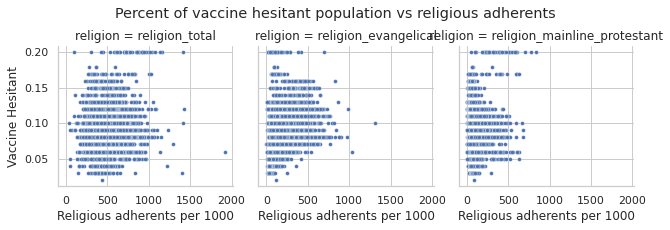

In [73]:
graph = sns.FacetGrid(df_narrow_religion, col='religion')
graph.map_dataframe(sns.scatterplot, x='value', y='vaccine_hesitant_strong', s=scatterplot_marker_size)
graph.fig.subplots_adjust(top=0.8)
graph.fig.suptitle('Percent of vaccine hesitant population vs religious adherents')
_ = graph.set_axis_labels("Religious adherents per 1000", "Vaccine Hesitant")

Our hypothesis going into this was religiosity had an effect on vaccine hesitancy, however these graphs don't show as strong a relationship as expected.

Total religious adherents doesn't seem to have a relationship with vaccine hesitancy

Evangelical adherent numbers have a slight uptake as vaccine hesitancy increases but then does not increase much after the mean.

Mainline protestant has a slight bell curve distribution with a some concentration on the upper end of vaccine hesitancy, however not very strongly.

Politics

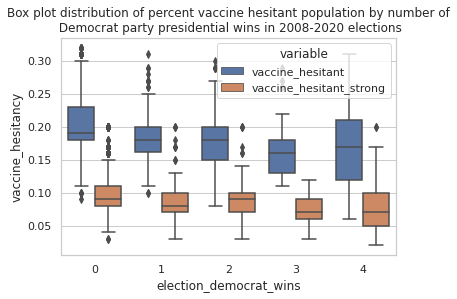

In [74]:
df_narrow_democrat_wins = df.melt(id_vars=['election_democrat_wins'], value_vars=['vaccine_hesitant', 'vaccine_hesitant_strong'], value_name='vaccine_hesitancy')
election_democrat_wins_boxplot = sns.boxplot(data=df_narrow_democrat_wins, x='election_democrat_wins', y='vaccine_hesitancy', hue='variable').set_title('Box plot distribution of percent vaccine hesitant population by number of\n Democrat party presidential wins in 2008-2020 elections')

# election_democrat_wins_boxplot = sns.boxplot(data=df, x='election_democrat_wins', y='vaccine_hesitant').set_title('Box plot distribution of percent vaccine hesitant population by number of\n Democrat party presidential wins in 2008-2020 elections')
# TODO: # votes democrat vs vaccine hesitancy

As the number of Democrat party presidential wins in 2008-2020 elections increase, we see a slight decrease in both vaccine hesitant and strongly vaccine hesitant populations. The last box plot with 4 Democrat wins is a bit of an outlier since vaccine hesitancy increases a bit, however the variance, shown by the whiskers, of the population is much larger.

Choropleth Visualization

In [77]:
import folium

df_map = df[['fips', 'vaccine_hesitant']].copy()
df_map['fips'] = df_map['fips'].astype(str)

map = folium.Map(location=[39.8282, -98.5795], zoom_start=5)
folium.Choropleth(
    geo_data='https://raw.githubusercontent.com/python-visualization/folium/master/tests/us-counties.json',
    name="choropleth",
    data=df_map,
    columns=['fips', 'vaccine_hesitant'],
    key_on='feature.id',
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Vaccine Hesitancy (%)",
).add_to(map)
folium.LayerControl().add_to(map)
map
# TODO: explore bivariate choropleth maps? hue (vaccine hesitancy) vs opacity (other demographic var)